In [1]:
# !python runner.py --fold 0 --log_dir out --version 0 --model DimeNet
# !python runner.py --fold 0 --log_dir out --version 0 --model CustomGNN_1
# !python runner.py --fold 0 --log_dir out --version 0 --model CustomGNN_2
# !python runner.py --fold 0 --log_dir out --version 0 --model CustomGNN_3

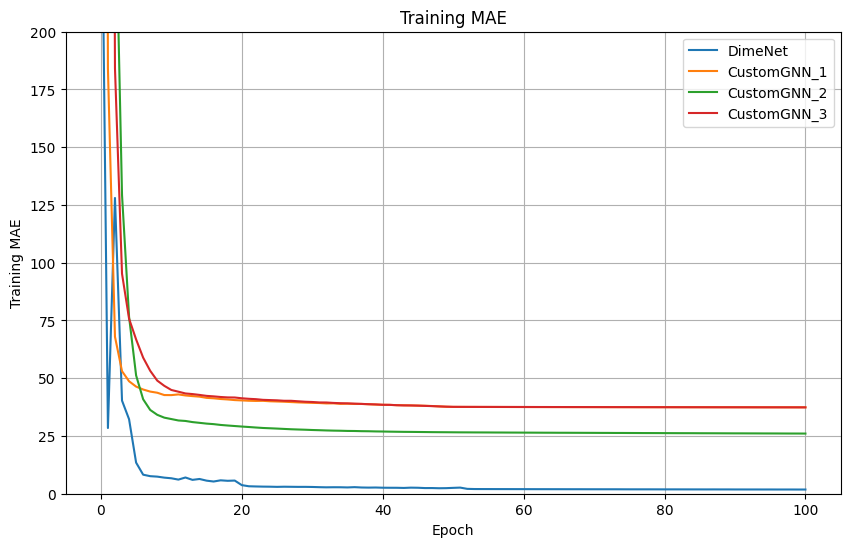

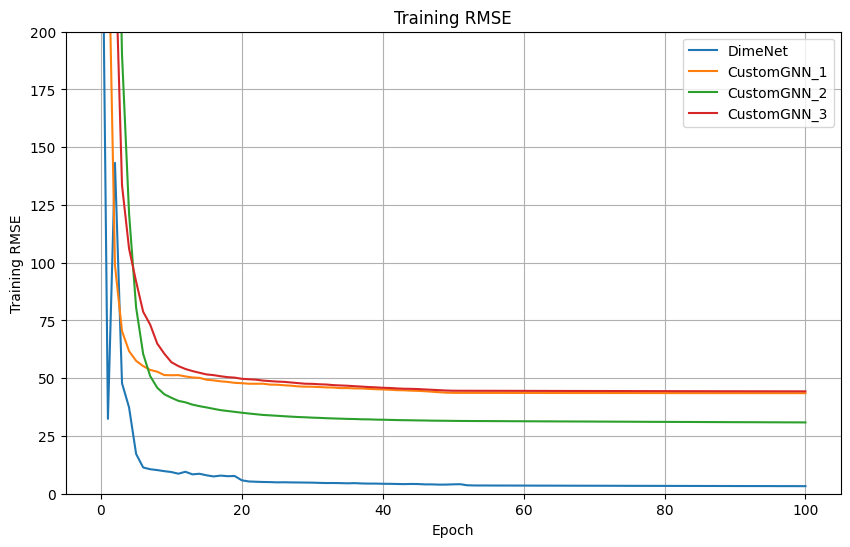

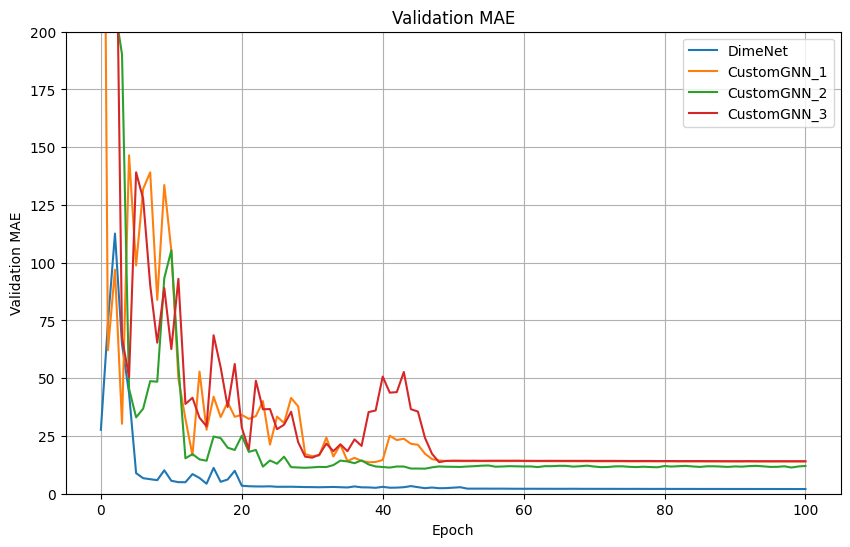

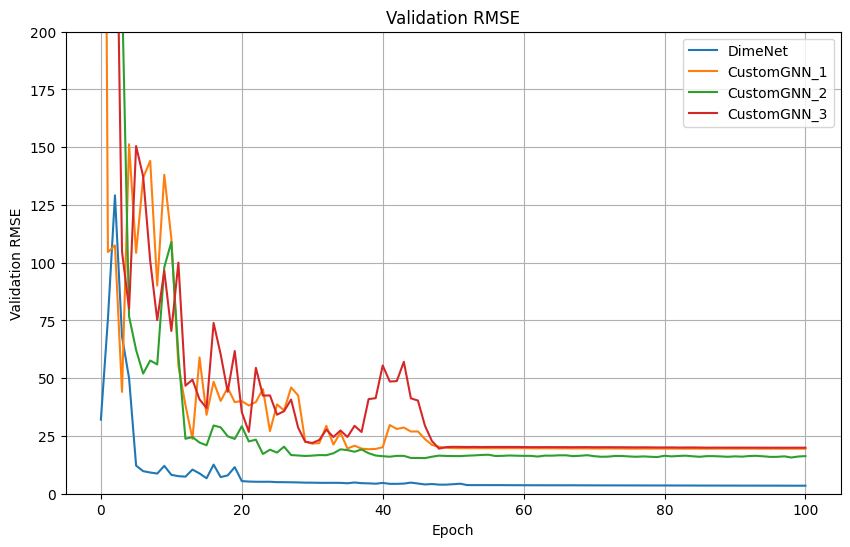


Final TEST_MAE values for each model:
DimeNet: 2.0321
CustomGNN_1: 13.9700
CustomGNN_2: 12.0066
CustomGNN_3: 14.0515

Final TEST_RMSE values for each model:
DimeNet: 3.4705
CustomGNN_1: 19.4811
CustomGNN_2: 16.2805
CustomGNN_3: 19.9272


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

log_dir = 'out'
models = ['DimeNet',
          'CustomGNN_1', 
          'CustomGNN_2', 
          'CustomGNN_3'
          ]

model_metrics = {}

# Load metrics
for model in models:
    file_path = os.path.join(log_dir, model, 'f0_0/metrics.csv')
    if os.path.exists(file_path):
        model_metrics[model] = pd.read_csv(file_path).groupby('epoch').mean()

# Define metrics to plot and their formal names
metrics_to_plot = {
    'train_mae': 'Training MAE',
    'train_rmse': 'Training RMSE',
    'val_mae': 'Validation MAE',
    'val_rmse': 'Validation RMSE',
}

# Plot metrics
for metric, formal_name in metrics_to_plot.items():
    plt.figure(figsize=(10, 6))
    
    for model, df in model_metrics.items():
        # Check if the metric column exists in the dataframe
        if metric in df.columns:
            plt.plot(df.index, df[metric], label=model)
    plt.ylim([0, 200])
    plt.grid(True)
    plt.title(formal_name)
    plt.xlabel('Epoch')
    plt.ylabel(formal_name)
    plt.legend()
    plt.show()

# Print the final test metrics
test_metrics = ['test_mae', 'test_rmse']

for metric in test_metrics:
    print(f"\nFinal {metric.upper()} values for each model:")
    for model, df in model_metrics.items():
        if metric in df.columns:
            final_value = df[metric].iloc[-1]
            print(f"{model}: {final_value:.4f}")


### Decomposition of DimeNet

In [7]:
import torch, os
import torch_geometric.transforms as T
import torch_geometric.utils as pyg_utils
import pytorch_lightning as pl
from pytorch_lightning.utilities import model_summary
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader as pyg_loader
from models import *

data_path = '../../data'

data_train = QM7(data_path, fold=0, train=True)
data_val = QM7(data_path, fold=0, train=False)

ckpt_path = 'out/best_model/DimeNet_f0_1-epoch=99-train_mae=1.81-val_mae=2.03.ckpt'

data_train.transform = T.Compose([PruneZeroCharge()])
data_val.transform = T.Compose([PruneZeroCharge()])

val_loader = pyg_loader(data_val, batch_size=64, shuffle=False)

dimenet_model = DimeNetModel()

# Load model from checkpoint
model = GNNPL.load_from_checkpoint(ckpt_path, model=dimenet_model)
trainer = pl.Trainer()

summary = model_summary.ModelSummary(model, max_depth=8)
print(summary)
result = trainer.validate(model, val_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


    | Name                                                       | Type                | Params
-----------------------------------------------------------------------------------------------------
0   | model                                                      | DimeNetModel        | 479 K 
1   | model.model                                                | DimeNetPlusPlus     | 479 K 
2   | model.model.rbf                                            | BesselBasisLayer    | 4     
3   | model.model.rbf.envelope                                   | Envelope            | 0     
4   | model.model.sbf                                            | SphericalBasisLayer | 0     
5   | model.model.sbf.envelope                                   | Envelope            | 0     
6   | model.model.emb                                            | EmbeddingBlock      | 18.8 K
7   | model.model.emb.emb                                        | Embedding           | 6.1 K 
8   | model.model.emb.lin_rbf     

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │    2.0220305919647217     │
│         val_rmse          │    3.6659984588623047     │
└───────────────────────────┴───────────────────────────┘


#### 1. Graph Data Input

In [4]:
from torch_geometric.nn import radius_graph
from torch_geometric.typing import SparseTensor

def triplets(edge_index, num_nodes) :
    
    row, col = edge_index  # j->i

    value = torch.arange(row.size(0))
    adj_t = SparseTensor(row=col, col=row, value=value,
                         sparse_sizes=(num_nodes, num_nodes))
    adj_t_row = adj_t[row]
    num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

    # Node indices (k->j->i) for triplets.
    idx_i = col.repeat_interleave(num_triplets)
    idx_j = row.repeat_interleave(num_triplets)
    idx_k = adj_t_row.storage.col()
    mask = idx_i != idx_k  # Remove i == k triplets.
    idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

    # Edge indices (k-j, j->i) for triplets.
    idx_kj = adj_t_row.storage.value()[mask]
    idx_ji = adj_t_row.storage.row()[mask]

    return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

sample = data_val[0]
pos = sample.pos
z = sample.z

edge_index = radius_graph(pos, r=3.0, max_num_neighbors=5) # Distance max 9.2

i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = triplets(
            edge_index, num_nodes=z.size(0))

# Calculate distances.
dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()
# print(dist.max())

# Calculate angles.
pos_jk, pos_ij = pos[idx_j] - pos[idx_k], pos[idx_i] - pos[idx_j]
a = (pos_ij * pos_jk).sum(dim=-1)
b = torch.cross(pos_ij, pos_jk, dim=1).norm(dim=-1)

angle = torch.atan2(b, a)

for (angle_ijk, i, j, k) in list(zip(angle, idx_i, idx_j, idx_k))[:2]:
    print(f"{i.item()}-{j.item()}-{k.item()}: {angle_ijk.item()}",)

0-1-2: 1.1803030967712402
0-1-6: 1.207415223121643


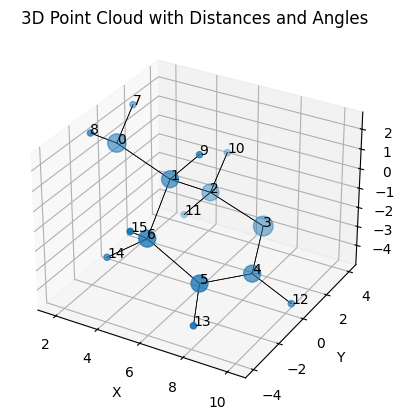

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

min_size, max_size = 20, 200 
norm = plt.Normalize(z.min().item(), z.max().item())
sizes = norm(z.numpy()) * (max_size - min_size) + min_size

# Plot points with colors based on charge
sc = ax.scatter(pos[:, 0].numpy(), pos[:, 1].numpy(), pos[:, 2].numpy(), s=sizes, marker='o')

for start, end in zip(edge_index[0], edge_index[1]):
    start_pos = pos[start].numpy()
    end_pos = pos[end].numpy()
    ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], [start_pos[2], end_pos[2]], 'k-', linewidth=0.5)

for idx, (x, y, z) in enumerate(pos):
    ax.text(x.item(), y.item(), z.item(), str(idx), color='black')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud with Distances and Angles')

plt.show()

#### 2. Encoding to RBF/SBF and Embedding

In [6]:
rbf = dimenet_model.model.rbf(dist)
sbf = dimenet_model.model.sbf(dist, angle, idx_kj)
print("dist, rbf, sbf:", dist.shape, rbf.shape, sbf.shape)
print(dist[:5])
print(rbf[:5])

dist, rbf, sbf: torch.Size([32]) torch.Size([32, 4]) torch.Size([56, 16])
tensor([1.9271, 1.9266, 2.7771, 2.9072, 2.9058])
tensor([[ 1.8224,  0.3548, -1.8064, -0.7183],
        [ 1.8231,  0.3561, -1.8068, -0.7207],
        [ 0.5022, -0.5951,  0.2064,  0.5436],
        [ 0.3548, -0.5041,  0.3054,  0.2764],
        [ 0.3563, -0.5052,  0.3049,  0.2790]], grad_fn=<SliceBackward0>)
